In [3]:
data = read.table('./mimosa/misoma/communityMetabolicPotentialScores.txt',header =T)

In [4]:
head(data)

,compound,Species,Sample,CMP
,<chr>,<chr>,<chr>,<dbl>
1,C00016,g__Acutalibacter.s__Acutalibacter_muris,KO-CLP1,5.345030
2,C00016,g__Acutalibacter.s__Acutalibacter_muris,KO-CLP4,0.284709
3,C00016,g__Acutalibacter.s__Acutalibacter_muris,KO-CLP5,0.247821
4,C00016,g__Acutalibacter.s__Acutalibacter_muris,KO-CLP6,0.604924
5,C00016,g__Acutalibacter.s__Acutalibacter_muris,KO-CLP7,0.492901
6,C00016,g__Acutalibacter.s__Acutalibacter_muris,KO-CLP8,2.950540


In [8]:
kegg = read.csv('./KEGG_COMPOUND_PATHWAY_mmu.csv')

In [11]:
head(kegg,2)

,Pathway,NAME,CLASS1,CLASS2,PATHWAY_MAP,COMPOUND,COMPOUND_DESCRIPTION
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,mmu00010,Glycolysis / Gluconeogenesis - Mus musculus (house mouse),Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,C00022,Pyruvate
2,mmu00010,Glycolysis / Gluconeogenesis - Mus musculus (house mouse),Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,C00024,Acetyl-CoA


In [13]:
library(dplyr)

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [20]:
keg = kegg %>% dplyr::filter(grepl('Lipid',CLASS2))

In [22]:
id = keg$COMPOUND

In [24]:
id2 = intersect(data$compound,id)

In [27]:
varshare = read.table('./mimosa/misoma/contributionResults.txt',header =T,sep = '\t')

In [51]:
varshare1 = varshare %>% filter(compound %in% id)

In [52]:
head(varshare1,2)

,compound,MetaboliteName,Rsq,VarDisp,ModelPVal,ModelPValFDRAdj,Slope,Intercept,Species,VarShare,NumSynthGenes,SynthGenes,NumDegGenes,DegGenes
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<chr>,<int>,<chr>
1,C00468,Estrone,0.1525784,245076.3,0.0004155941,0.05818317,381.5073,1456.666,g__Acutalibacter.s__Acutalibacter_muris,0,NA,NA,NA,NA
2,C00468,Estrone,0.1525784,245076.3,0.0004155941,0.05818317,381.5073,1456.666,g__Adlercreutzia.s__Adlercreutzia_equolifaciens,0,NA,NA,NA,NA


In [53]:
networ = as.data.frame(varshare1)
# 构造一个向量用于承接正负关系
aa = rep(1,length(networ$VarShare))
for (i in 1:length(networ$VarShare)) {
  if (networ$VarShare[i]> 0) {
    aa[i] = 1
  }else{
    aa[i] = -1
  }
}

In [54]:
edge = data.frame(compound = networ$MetaboliteName,tax =networ$Species,value = networ$VarShare,direct= "directed",N_P = aa)
# head(edge)
#构造节点文件，代谢物和微生物共同组成，对分泌物的预测预测效果R值标记为一列
node = data.frame(ID= c(unique(networ$MetaboliteName), unique(networ$Species) ),R =  c(unique(networ$Rsq),rep("NA",length(unique(networ$Species)))))

In [55]:
suppressWarnings(suppressMessages(library(ggcorrplot)))
suppressWarnings(suppressMessages(library(igraph)))
suppressWarnings(suppressMessages(library(psych)))
suppressWarnings(suppressMessages(library(network)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(sna)))
suppressWarnings(suppressMessages(library(ergm)))
suppressWarnings(suppressMessages(library(ggrepel)))
suppressWarnings(suppressMessages(library("mimosa")))
suppressWarnings(suppressMessages(library(data.table)))

In [56]:
.libPaths(c('/root/miniconda3/envs/metadoc/lib/R/library','/root/miniconda3/envs/Rdoc/lib/R/library'))

In [57]:
G <- graph.data.frame(edge ,directed=FALSE);
#转化为邻接矩阵，attr：填充权重
occor.r<- as_adjacency_matrix(G,type="both",names=TRUE,sparse=FALSE,attr="value");


#构造网络文件，network包提供
g <- network(occor.r, directed=FALSE)
# (summary(g))
#做没有权重的邻接矩阵
m <- as.matrix.network.adjacency(g)  # get sociomatrix
#设置可视化layout
plotcord <- data.frame(gplot.layout.fruchtermanreingold(m, NULL))
#添加表头
colnames(plotcord) = c("X1", "X2")
#添加节点名称
plotcord$elements <- colnames(occor.r)
#制作边文件
edglist <- as.matrix.network.edgelist(g)
edglist = as.data.frame(edglist)
# head(edglist)
#添加边的权重
set.edge.value(g,"weigt",occor.r)
edglist$weight = as.numeric(network::get.edge.attribute(g,"weigt"))
# dim(edglist)
#添加其他信息
edges <- data.frame(plotcord[edglist[, 1], ], plotcord[edglist[, 2], ])
# head(edges)
edges$weight = as.numeric(network::get.edge.attribute(g,"weigt"))

In [58]:
aaa = rep("a",length(edges$weight))
for (i in 1:length(edges$weight)) {
  if (edges$weight[i]> 0) {
    aaa[i] = "+"
  }
  if (edges$weight[i]< 0) {
    aaa[i] = "-"
  }
}
#添加到edges中
edges$wei_label = as.factor(aaa)
colnames(edges) <- c("X1", "Y1","OTU_1", "X2", "Y2","OTU_2","weight","wei_label")
# head(edges)

##plotcord这个表格添加注释
row.names(plotcord) = plotcord$elements
row.names(node) = node$ID
#合并之前制作的节点文件
index = merge(plotcord,node,by = "row.names",all = T)
# dim(index)
# head(index)
index$R = as.numeric(as.character(index$R))
#这里我为了突出代谢物，将全部微生物节点大小定义为代谢物的十分之一
index$R [is.na(as.numeric(as.character(index$R)))] = min(as.numeric(as.character(index$R)),na.rm = TRUE)/10
plotcord = index
#网络出图
pnet <- ggplot() + geom_segment(aes(x = X1, y = Y1, xend = X2, yend = Y2,color = as.factor(wei_label)),
                                data = edges, size = 0.5) +
  geom_point(aes(X1, X2,size=R),pch = 21,color = "black",fill = "red", data = plotcord) + scale_colour_brewer(palette = "Set1") +
  scale_x_continuous(breaks = NULL) + scale_y_continuous(breaks = NULL) +
  # labs( title = paste(layout,"network",sep = "_"))+
  geom_text_repel(aes(X1, X2,label=elements),size=4, data = plotcord)+
  # discard default grid + titles in ggplot2
  theme(panel.background = element_blank()) +
  # theme(legend.position = "none") +
  theme(axis.title.x = element_blank(), axis.title.y = element_blank()) +
  theme(legend.background = element_rect(colour = NA)) +
  theme(panel.background = element_rect(fill = "white",  colour = NA)) +
  theme(panel.grid.minor = element_blank(), panel.grid.major = element_blank())



Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [61]:
options(repr.plot.height  =12,repr.plot.width = 12)

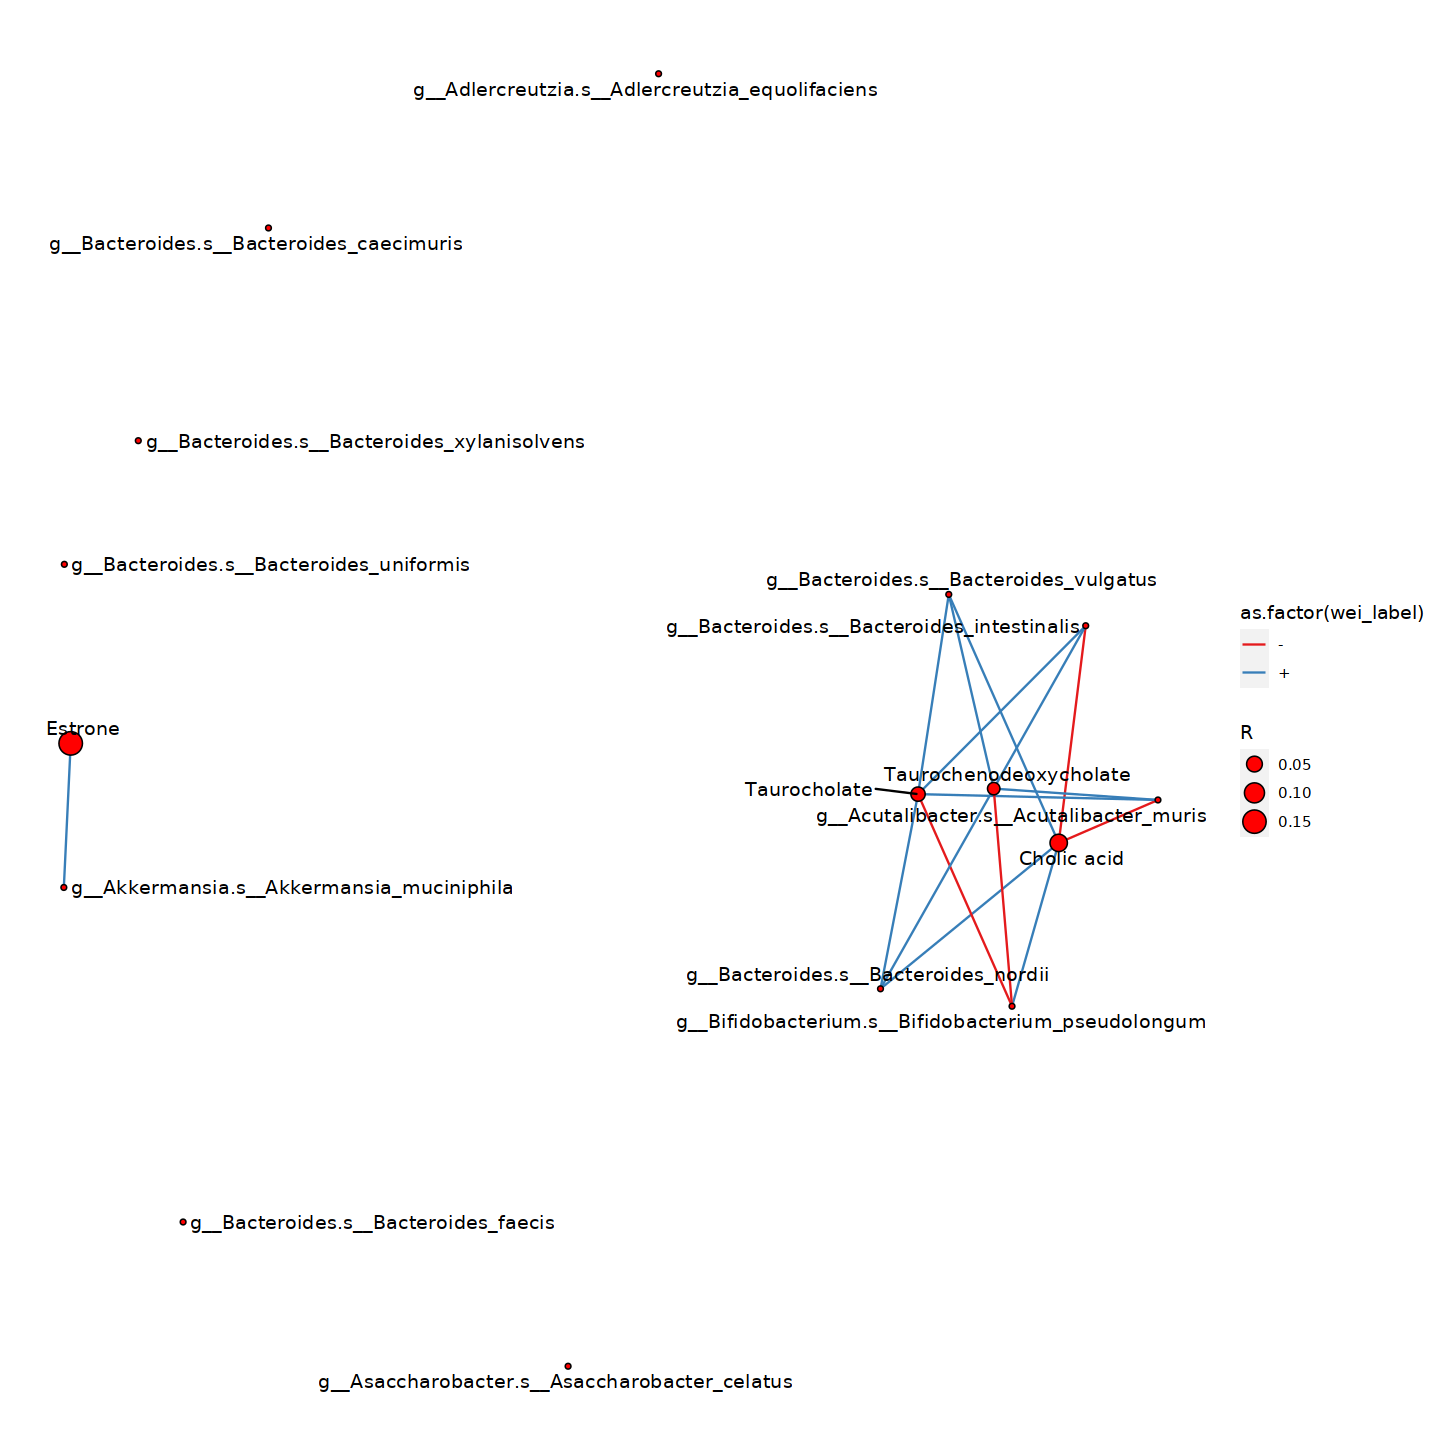

In [62]:
pnet